# Przeanalizowanie danych z ostatnich lat Serie A oraz wykorzystać ich do przewidywania ich potencjalnego rozwoju w następnym sezonie.

In [1]:
import os

from ipywidgets import widgets
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import mpldatacursor
import numpy as np
import pandas as pd
import seaborn as sns

In [7]:
# Nazwy do zapisów
FILENAME_DATA = 'dataset-multiyear.csv'

%matplotlib notebook
sns.set()

## Ładowanie i selekcja cech

Dataset jest to zbiór statystyk z 4 sezonów Serie A (via Fantagazzetta), zawierający również ocenę jego gry według ekspertów oraz użytkowników. 

In [8]:
# Wczytywanie bazy
filepath_data = os.path.join(FILENAME_DATA)
df = pd.read_csv(filepath_data)

Usuwamy zawodników którzy rozegrali mniej niż 10 meczy w ostatnim sezonie. Powodem jest za mała próbka.

In [9]:
N_MIN_GAMES = 10
df = df[df['Pg1617'] > N_MIN_GAMES]

Ustale jeszcze by zawownicy przez 2 ostatnie sezony grali w Serie A oraz by pominąć wyniki zerowe. 

In [42]:
cols_mf = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
idxs_to_remove_last_seasons = df[cols_mf[-2:]].isnull().any(axis=1)  # sprawdzenie gry w osatnich sezonach
idxs_to_remove_zeros = df[cols_mf[-1]] == 0  # oceny równe 0, by pominąć błędne informacje w danych
idxs_to_remove = idxs_to_remove_last_seasons| idxs_to_remove_zeros
df_updated = df[~idxs_to_remove]

# Preview data
df_updated.head()
#print (len(df_updated))

,Name,Yc1314,Yc1415,Yc1516,Yc1617,Ass1516,Ass1617,Asr1314,Asr1415,Asr1516,...,Pk1516,Pk1617,Ps1314,Ps1415,Ps1516,Ps1617,Team1314,Team1415,Team1516,Team1617
0,ABATE,1.0,5.0,7.0,2.0,0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,MILAN,MILAN,Milan,Milan
2,ACERBI,1.0,7.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,SASSUOLO,SASSUOLO,Sassuolo,Sassuolo
5,ACQUAH,6.0,9.0,9.0,2.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,PARMA,SAMPDORIA,Torino,Torino
8,ADNAN,NaN,NaN,6.0,2.0,0.0,0.0,NaN,NaN,1.0,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,Udinese,Udinese
17,ALBIOL,5.0,10.0,10.0,8.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NAPOLI,NAPOLI,Napoli,Napoli


Powyższych warunków nie spełnia 104 zawodników.

Całkowita liczba danych wynosi 265 zawodników. Biorąc pod uwagę spadki oraz awanse drużyn z ligi, jak również transfery zawodników z/do lig zagranicznych, liczba próbek wygląda sensownie.  

# Trendy w danych

Zawodnicy o stałym rozwoju przez kolejne sezony. 

In [63]:
COLS_TRENDS = ['Name', 
               'Delta1', 'Delta2', 'Delta3', 
               'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']

data_progres_trend = []
for id_player in df_updated.index:  
    player = df_updated.loc[id_player]
    # Obliczenia róźnicy między oceną poszczególnych sezonów
    curr_mf = player[cols_mf].dropna()
    curr_deltas = [0] * (4 - len(curr_mf))  # delta == 0 dla braku danych
    curr_deltas.extend([curr_mf[i+1] - curr_mf[i] \
                        for i in range(len(curr_mf) - 1)])
    n_negative_deltas = sum(np.array(curr_deltas) < 0) #sprawdzenie
    if n_negative_deltas == 0:
        # nowy dataset
        row = [player['Name']]
        row.extend(curr_deltas)
        row.extend(player[cols_mf])
        data_progres_trend.append(row)

df_progres_trend = pd.DataFrame(data=data_progres_trend, 
                                 columns=COLS_TRENDS)
print ("Liczba zawodników z zauważalnym progresie:", len(df_progres_trend))
df_progres_trend.head()

Liczba zawodników z zauważalnym progresie: 58


,Name,Delta1,Delta2,Delta3,Sf1314,Sf1415,Sf1516,Sf1617
0,ANTEI,0.19,0.09,0.13,5.52,5.71,5.80,5.93
1,BABACAR,0.00,0.10,0.37,NaN,7.08,7.18,7.55
2,BADELJ,0.00,0.27,0.10,NaN,5.71,5.98,6.08
3,BALOGH,0.00,0.00,0.27,NaN,NaN,5.00,5.27
4,BARRETO E,0.00,0.00,0.51,NaN,NaN,5.57,6.08


<IPython.core.display.Javascript object>


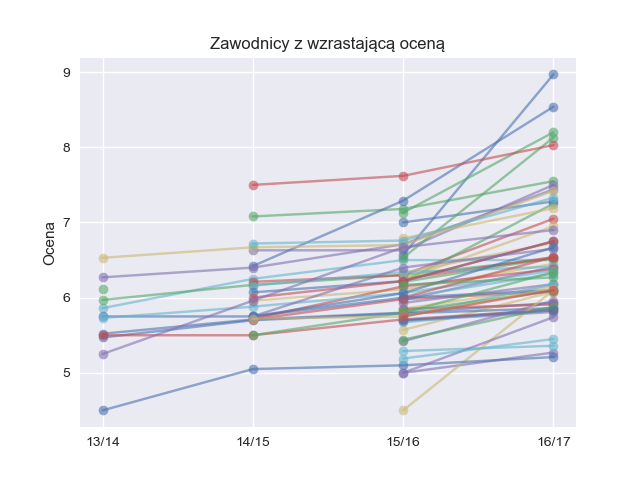

In [64]:
X_TICKS = ['13/14', '14/15', '15/16', '16/17']
#names = ['DZEKO',
#          'BELOTTI',
#          'SZCZESNY']
names = []

if len(names) > 0:
    data = df_progres_trend[df_progres_trend['Name'].isin(names)]
    data = data.sort_values(['Sf1617'], ascending=False)
    names = data['Name'].values
    data = data.values[:, 4:]
else:
    data = df_progres_trend.values[:, 4:]

fig, ax = plt.subplots()
for i_row, row in enumerate(data):  
    if len(names) > 0:
        curr_label = names[i_row]
    else:
        curr_label = df_progres_trend.iloc[i_row, :]['Name']
    ax.plot(row, marker='o', alpha=0.6, label=curr_label)
    
# Wykorzystanie kursora do sprawdzenia zawodnika
mpldatacursor.datacursor(formatter='{label}'.format)

# Wykres
plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Zawodnicy z wzrastającą oceną')
plt.ylabel('Ocena')
if len(names) > 0:
    plt.legend()

Zawodników ze stałym rozwojem jest 58, w znacznej większości są to zawodnicy ofensywni. W zestawieniu znajdują się co ciekawe 5 bramkarzy. 

Zawodnicy którzy regularnie zaliczyli regres.

In [73]:
COLS_TRENDS = ['Name', 
               'Delta1', 'Delta2', 'Delta3', 
               'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']

data_regres_trend = []
for id_player in df_updated.index:  
    player = df_updated.loc[id_player]
    curr_mf = player[cols_mf].dropna()
    curr_deltas = [0] * (4 - len(curr_mf))  
    curr_deltas.extend([curr_mf[i+1] - curr_mf[i] \
                        for i in range(len(curr_mf) - 1)])
    n_progres_deltas = sum(np.array(curr_deltas) > 0)
    if n_progres_deltas == 0:
        row = [player['Name']]
        row.extend(curr_deltas)
        row.extend(player[cols_mf])
        data_regres_trend.append(row)
        
df_regres_trend = pd.DataFrame(data=data_regres_trend, 
                                 columns=COLS_TRENDS)
print ("Number of players with regres trend:", len(df_regres_trend))
df_regres_trend.head()

Number of players with regres trend: 46


,Name,Delta1,Delta2,Delta3,Sf1314,Sf1415,Sf1516,Sf1617
0,ADNAN,0.0,0.0,-0.51,NaN,NaN,6.05,5.54
1,ALEX SANDRO,0.0,0.0,-0.32,NaN,NaN,6.74,6.42
2,ALVAREZ R,0.0,0.0,-0.10,NaN,NaN,6.19,6.09
3,ANSALDI,0.0,0.0,-0.48,NaN,NaN,6.10,5.62
4,BACCA,0.0,0.0,-0.67,NaN,NaN,7.54,6.87


<IPython.core.display.Javascript object>


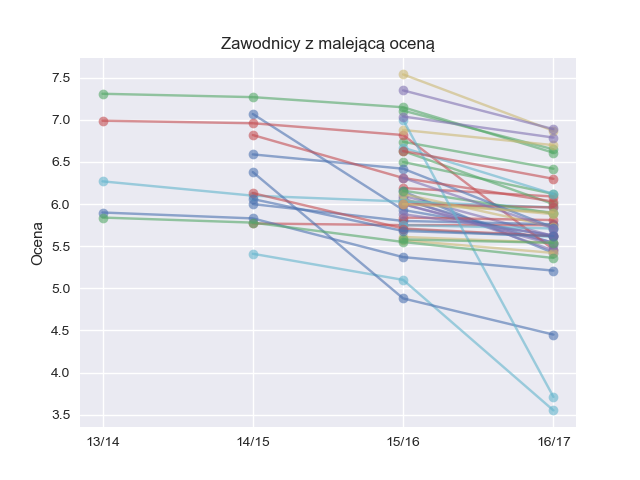

In [79]:
X_TICKS = ['13/14', '14/15', '15/16', '16/17']

names = []

if len(names) > 0:
    data = df_regres_trend[df_regres_trend['Name'].isin(names)]
    data = data.sort_values(['Sf1617'], ascending=False)
    names = data['Name'].values
    data = data.values[:, 4:]
else:
    data = df_regres_trend.values[:, 4:]

fig, ax = plt.subplots()
for i_row, row in enumerate(data):
    if len(names) > 0:
        curr_label = names[i_row]
    else:
        curr_label = df_regres_trend.iloc[i_row, :]['Name']
    ax.plot(row, marker='o', alpha=0.6, label=curr_label)
    
mpldatacursor.datacursor(formatter='{label}'.format)

plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Zawodnicy z malejącą oceną')
plt.ylabel('Ocena')
if len(names) > 0:
    plt.legend()

46 zawodników przyjmujących stały regres formy. Większość to zawodnicy z formacji obronnej oraz zawodnicy już u schyłku kariery.

# Różnica między pierwszym sezonem gry a ostatnim.

By zneutralizować działanie wachań formy (słabszy sezon zawodnika), obliczam różnicę między pierwszym a ostatnim sezonem 
zawodnika.

In [76]:
COLS_MF = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
COLS_DELTAS = ['Name', 'Delta', 'Squadra1617',
               'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
data_deltas = []
for id_player in df_updated.index: 
    player = df_updated.loc[id_player]
    curr_mf = player[COLS_MF].dropna()
    curr_delta = curr_mf[-1] - curr_mf[0]
    # Stworzenie dataset
    row = [player['Name']]
    row.append(curr_delta)
    row.append(player['Team1617'])
    row.extend(player[COLS_MF])
    data_deltas.append(row)
    
df_deltas = pd.DataFrame(data=data_deltas, columns=COLS_DELTAS)
df_deltas = df_deltas.sort_values(['Delta'])  # sortowanie
df_deltas.head()

,Name,Delta,Squadra1617,Sf1314,Sf1415,Sf1516,Sf1617
209,POSAVEC,-3.29,Palermo,NaN,NaN,7.00,3.71
148,LAMANNA,-1.93,Genoa,NaN,6.38,4.88,4.45
32,BIZZARRI,-1.86,Pescara,NaN,5.41,5.10,3.55
79,DESTRO,-1.82,Bologna,8.44,6.63,6.65,6.62
191,PALACIO,-1.66,Inter,7.57,6.53,6.55,5.91


Wykres z najorszą róźnicą.

<IPython.core.display.Javascript object>


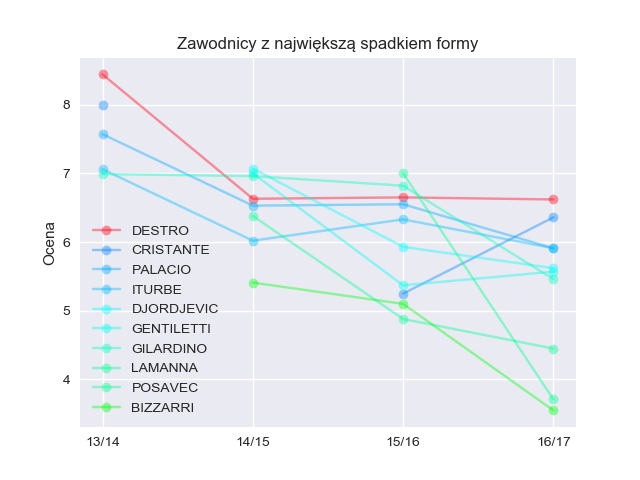

In [81]:
X_TICKS = ['13/14', '14/15', '15/16', '16/17']

# Warunku
N = 10
df_deltas_worst = df_deltas.iloc[:N, :]
data = df_deltas_worst.sort_values(['Sf1617'], ascending=False)
labels = data['Name'].values
data = data.values[:, 3:]
delta_min = df_deltas_worst['Delta'].min()

# Wykres
fig, ax = plt.subplots()
for i_row, row in enumerate(data): 
    curr_delta = df_deltas_worst.iloc[i_row, :]['Delta']
    curr_label = labels[i_row]
    curr_col = cm.hsv(abs(curr_delta / delta_min))
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)

mpldatacursor.datacursor(formatter='{label}'.format)

plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Zawodnicy z największą spadkiem formy')
plt.ylabel('Ocena')
plt.legend()

<IPython.core.display.Javascript object>


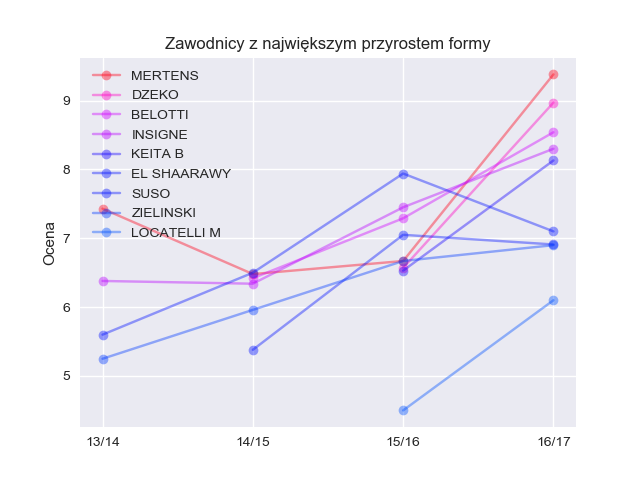

In [83]:

X_TICKS = ['13/14', '14/15', '15/16', '16/17']

# Dane
N = 10 
df_deltas_best = df_deltas.iloc[range(len(df_deltas)-1, len(df_deltas)-N, -1), :]
data = df_deltas_best.sort_values(['Sf1617'], ascending=False)
labels = data['Name'].values
data = data.values[:, 3:]
delta_max = df_deltas_best['Delta'].max()

# Wykres
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  
    curr_delta = df_deltas_best.iloc[i_row, :]['Delta']
    curr_label = labels[i_row]
    curr_col = cm.hsv(curr_delta / delta_max)
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
mpldatacursor.datacursor(formatter='{label}'.format)

plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Zawodnicy z największym przyrostem formy')
plt.ylabel('Ocena')
plt.legend()

# Oszacowanie ratingu zawodnika na podstawie średniej ze wszystkich sezonów.

In [84]:
COLS_MF = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
COLS_MEANS = ['Name', 'Mean', 'Squadra1617', 'R1617',
               'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
data_means = []
for id_player in df_updated.index:  
    player = df_updated.loc[id_player]
    # Obliczanie średniej
    curr_mf = player[COLS_MF].dropna()
    curr_mean = np.mean(curr_mf)
    # Tworzenie dataset
    row = [player['Name']]
    row.append(curr_mean)
    row.append(player['Team1617'])
    row.append(player['R1617'])
    row.extend(player[COLS_MF])
    data_means.append(row)
    
df_means = pd.DataFrame(data=data_means, columns=COLS_MEANS)
df_means = df_means.sort_values(['Mean'])  
df_means.head()

,Name,Mean,Squadra1617,R1617,Sf1314,Sf1415,Sf1516,Sf1617
216,RAFAEL,4.600000,Cagliari,G,4.46,4.72,4.08,5.14
32,BIZZARRI,4.686667,Pescara,G,NaN,5.41,5.10,3.55
236,SORRENTINO,4.713333,Chievo,G,NaN,4.74,4.69,4.71
70,DA COSTA,4.750000,Bologna,G,4.50,NaN,5.00,4.75
139,KARNEZIS,4.793333,Udinese,G,NaN,5.05,4.63,4.70


Zawodnicy z najgorszą średnią.

<IPython.core.display.Javascript object>


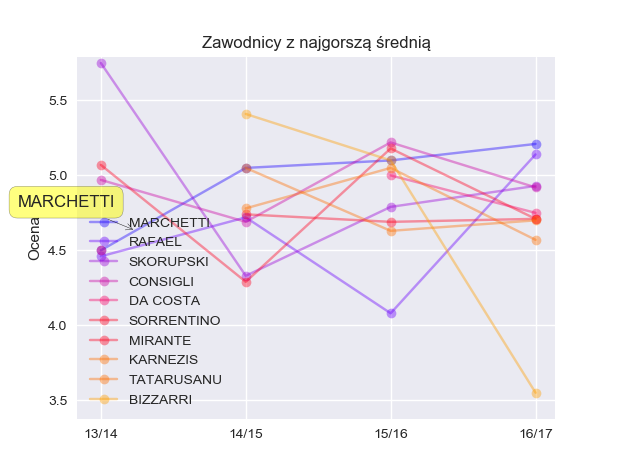

In [87]:
X_TICKS  = ['13/14', '14/15', '15/16', '16/17']

N = 10
df_means.iloc[:N, :]

N = 10
df_means_worst = df_means.iloc[:N, :]
data = df_means_worst.sort_values(['Sf1617'], ascending=False)
labels = data['Name'].values
data = data.values[:, 4:]
mean_max = df_means['Mean'].max()

fig, ax = plt.subplots()
for i_row, row in enumerate(data):  
    curr_mean = df_means_worst.iloc[i_row, :]['Mean']
    curr_label = labels[i_row]
    curr_col = cm.prism(curr_mean / mean_max)
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
mpldatacursor.datacursor(formatter='{label}'.format)

plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Zawodnicy z najgorszą średnią')
plt.ylabel('Ocena')
plt.legend()

Wszyscy z zawodników to bramkarze, spowodowane jest to brakiem strzelonych bramek czy asyst które podwyższają ocenę.

Zawodnicy z najwyższą średnią.

<IPython.core.display.Javascript object>


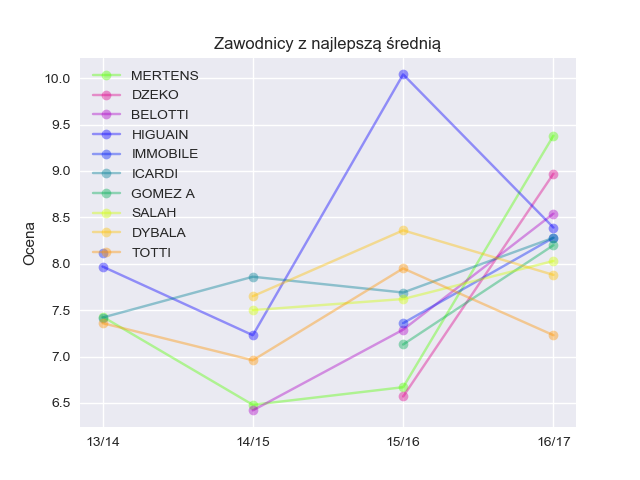

In [85]:
X_TICKS = ['13/14', '14/15', '15/16', '16/17']

N = 10 + 1
df_means_best = df_means.iloc[range(len(df_means)-1, len(df_means)-N, -1), :]
data = df_means_best.sort_values(['Sf1617'], ascending=False)
labels = data['Name'].values
data = data.values[:, 4:]
mean_max = df_means_best['Mean'].max()

# Wykres
fig, ax = plt.subplots()
for i_row, row in enumerate(data):  
    curr_mean = df_means_best.iloc[i_row, :]['Mean']
    curr_label = labels[i_row]
    curr_col = cm.prism(curr_mean / mean_max)
    ax.plot(row, marker='o', 
            c=curr_col, alpha=0.4,
            label=curr_label)
    
mpldatacursor.datacursor(formatter='{label}'.format)

plt.xticks(range(len(X_TICKS)), X_TICKS)
plt.title('Zawodnicy z najlepszą średnią')
plt.ylabel('Ocena')
plt.legend()

Tutaj zawodnicy to napastnicy. Teraz sprawdzenie ze względu na pozycje na boisku.

<IPython.core.display.Javascript object>


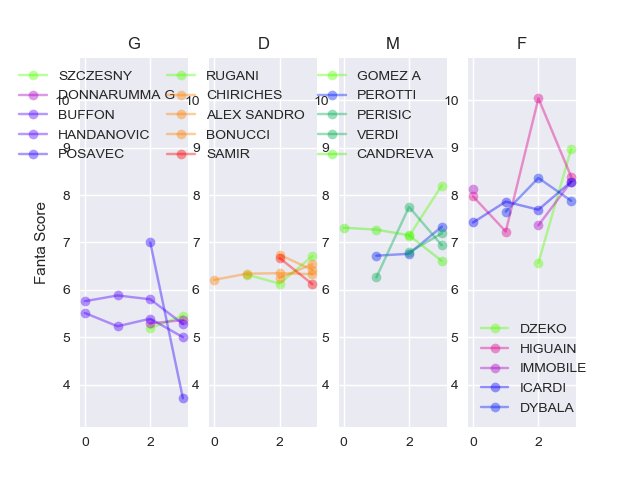

In [90]:
#Pozycje
pozycje = ['G', 'D', 'M', 'F']
X_TICKS = ['13/14', '14/15', '15/16', '16/17']
N = 5 + 1

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
ax = (ax1, ax2, ax3, ax4)

for (i_pozycja, pozycja) in enumerate(pozycje):  
    
    df_means_pozycja = df_means[df_means['R1617'] == pozycja]
    df_means_best_pozycja = df_means_pozycja.iloc[range(len(df_means_pozycja)-1, len(df_means_pozycja)-N, -1), :]
    data = df_means_best_pozycja.sort_values(['Sf1617'], ascending=False)
    labels = data['Name'].values
    data = data.values[:, 4:]
    mean_max = df_means_best_pozycja['Mean'].max()

    for i_row, row in enumerate(data):  
        curr_mean = df_means_best_pozycja.iloc[i_row, :]['Mean']
        curr_label = labels[i_row]
        curr_col = cm.prism(curr_mean / mean_max)
        ax[i_pozycja].plot(row, marker='o', 
                        c=curr_col, alpha=0.4,
                        label=curr_label)

    mpldatacursor.datacursor(formatter='{label}'.format)

    ax[i_pozycja].set_xticks(range(len(X_TICKS)), X_TICKS)
    ax[i_pozycja].set_title(pozycja)
    if i_pozycja == 0:
        ax[i_pozycja].set_ylabel('Fanta Score')
    ax[i_pozycja].legend()
    ax[i_pozycja].set_ylim([3.1, 10.9])

Przykłady Posaveca oraz Higuaina pokazują, że wystarczy jeden sezon zdecydowanie ponad możliwości by znaleźć się w czołówce.

# Najlepsi w przyszłym sezonie

Wykorzystując wcześniejsze obliczenia, tworzymy wskażniki ,,mocy" zawodnika by dobrać takich - którzy z największym prawdopodobieństwem będą kluczowymi zawodnikami w kolejnym sezonie.

Korzystamy z parametrów:

-Ocena różnicy między pierwszym a ostatnim sezonem.

-Rating z kariery.

-Przyrost/Regres formy.

-Liczba lat gry w Serie A.

-Średnia ocena z ostatniego sezonu.

Prosta formuła może pomóc w przybliżeniu wydajności każdego pojedynczego gracza w następnym sezonie Serie A. Oblicza następującą sumę ważoną:


Wybierając różne wagi, można nadać mniej lub bardziej istotne znaczenie określonym aspektom kariery piłkarza.

Formuła zwraca wynik na przyszły sezon. Wartości są sortowane od najlepszych zawodników.

In [99]:
def _sort_players_by_weighted_score(df, w_d, w_m, w_t, w_y, role=''):
    # Constants
    COLS_MF = ['Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
    COLS_REDUX = ['Name', 'R1617', 'Team1617', 'Sf1314', 'Sf1415', 'Sf1516', 'Sf1617']
    COLS_WEIGHTS = ['Name', 'R1617', 'Team1617', 'Sf1617',
                    'WeightedScore', 'DeltaScore', 'MeanScore', 'TrendScore', 'YearsScore']
    # Filtr Danych
    df_redux = df[COLS_REDUX]
    if len(role) > 0:
        df_redux = df_redux[df_redux['R1617'] == role]
    data_weight_score = []
    for id_player in df_redux.index:  
        player = df_redux.loc[id_player]
        name = player['Name']
        
        # Obliczanie wagi
        score = df_redux['Sf1617'].values[0]
        score_d = w_d * df_deltas[df_deltas['Name'] == name]['Delta'].values[0]
        score_m = w_m * df_means[df_means['Name'] == name]['Mean'].values[0]
        score_t = 0
        if name in df_progres_trend['Name'].values:
            score_t = w_t
        curr_mf = player[COLS_MF].dropna()
        score_y = w_y * len(curr_mf)
        score_weighted = score + score_d + score_m + score_t + score_y
        # Dodanie dataset
        row = [name]
        row.append(player['R1617'])
        row.append(player['Team1617'])
        row.append(player['Sf1617'])
        row.append(score_weighted)
        row.extend([score_d, score_m, score_t, score_y])
        data_weight_score.append(row)
   
    df_weight_scores = pd.DataFrame(data=data_weight_score, 
                                    columns=COLS_WEIGHTS)
    df_weight_scores = df_weight_scores.sort_values(['WeightedScore'])
    return df_weight_scores

In [106]:
from IPython.display import clear_output
plt.style.use('ggplot')

#Okienko
WIDTH_TEXT = 50
text_delta = widgets.FloatText(description="Różnica Weight", 
                          value="0.8",
                          width=WIDTH_TEXT)
text_mean = widgets.FloatText(description="Średnia Weight", 
                          value="0.7",
                          width=WIDTH_TEXT)
text_trend = widgets.FloatText(description="Trend Weight", 
                          value="1.0",
                          width=WIDTH_TEXT)
text_years = widgets.FloatText(description="Wiek Weight", 
                          value="0.8",
                          width=WIDTH_TEXT)
display(text_delta)
display(text_mean)
display(text_trend)
display(text_years)

# POZYCJE
dropdown_role =  widgets.Dropdown(
    options=['G', 'D', 'M', 'F', 'All'],
    value='F',
    description='Role:',
    disabled=False,
)
display(dropdown_role)

# Przycisk
button_calculate = widgets.Button(description="Oblicz")
display(button_calculate)
def on_button_clicked(b):
    # Wartości
    w_d = float(text_delta.value)
    w_m = float(text_mean.value)
    w_t = float(text_trend.value)
    w_y = float(text_years.value)
    role = dropdown_role.value
    if len(role) != 1:
        role = ''
    # Najlepsi zawodnicy
    N = 20
    df_weighted_scores = _sort_players_by_weighted_score(df_updated, 
                                                         w_d, w_m, w_t, w_y, role)
    clear_output()
    print (df_weighted_scores.iloc[range(len(df_weighted_scores)-1, 
                                        len(df_weighted_scores)-N, -1), :])
 
button_calculate.on_click(on_button_clicked)

            Name R1617    Team1617  Sf1617  WeightedScore  DeltaScore  \
17      SZCZESNY     G        Roma    5.45       8.122000       0.208   
5   DONNARUMMA G     G       Milan    5.36       7.973500       0.056   
9      MARCHETTI     G       Lazio    5.21       6.233500       0.568   
19       VIVIANO     G   Sampdoria    5.18       5.824000       0.008   
14         REINA     G      Napoli    5.14       5.779000      -0.072   
4       DA COSTA     G     Bologna    4.75       5.715000       0.200   
16    SORRENTINO     G      Chievo    4.71       5.465333      -0.024   
18    TATARUSANU     G  Fiorentina    4.57       5.382000      -0.168   
7       KARNEZIS     G     Udinese    4.70       5.265333      -0.280   
0        BERISHA     G    Atalanta    5.19       5.178500       0.408   
13        RAFAEL     G    Cagliari    5.14       4.954000       0.544   
2         BUFFON     G    Juventus    5.28       4.782000      -0.384   
11         PERIN     G       Genoa    5.03       4.

In [108]:
df_updated.head()


,Name,Yc1314,Yc1415,Yc1516,Yc1617,Ass1516,Ass1617,Asr1314,Asr1415,Asr1516,...,Pk1516,Pk1617,Ps1314,Ps1415,Ps1516,Ps1617,Team1314,Team1415,Team1516,Team1617
0,ABATE,1.0,5.0,7.0,2.0,0.0,0.0,0.0,3.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,MILAN,MILAN,Milan,Milan
2,ACERBI,1.0,7.0,3.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,SASSUOLO,SASSUOLO,Sassuolo,Sassuolo
5,ACQUAH,6.0,9.0,9.0,2.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,PARMA,SAMPDORIA,Torino,Torino
8,ADNAN,NaN,NaN,6.0,2.0,0.0,0.0,NaN,NaN,1.0,...,0.0,0.0,NaN,NaN,0.0,0.0,NaN,NaN,Udinese,Udinese
17,ALBIOL,5.0,10.0,10.0,8.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,NAPOLI,NAPOLI,Napoli,Napoli
